ibmqfactory.load_account:WARNING:2023-11-17 21:52:48,934: Credentials are already in use. The existing account in the session will be replaced.
C:\Users\DELL\AppData\Local\Temp\ipykernel_5656\1249773447.py:87: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(assemble(transpiled_circuit)).result()


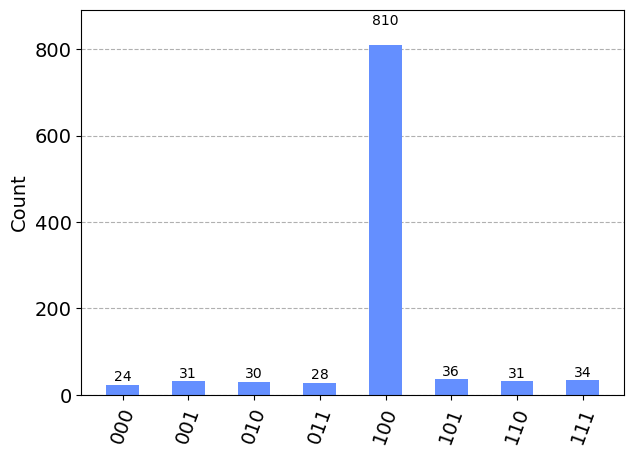

In [7]:
from qiskit import QuantumCircuit, Aer, transpile, assemble, IBMQ
from qiskit.visualization import plot_histogram

# Load your IBM Quantum Experience account
IBMQ.save_account('460c8dda94aea888724dfc4bbb2e142c8a04074a3264623ed3523acef02e3798a8a843a9918ac29d36ca35d78a304e1be68ac4c1bc5f5d1889867033f72ee07f', overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibm_lagos')

def grover_circuit(n, marked_item):
    # Create a quantum circuit with n qubits and n classical bits
    grover_circ = QuantumCircuit(n, n)

    # Apply Hadamard gate to all qubits
    grover_circ.h(range(n))

    # Apply the Grover iteration
    for _ in range(int(n**0.5)):  # Number of iterations for amplitude amplification
        # Oracle: Mark the item
        grover_circ.barrier()
        for i in range(n):
            grover_circ.x(i) if marked_item[i] == '1' else None
        grover_circ.append(oracle(n), range(n))
        for i in range(n):
            grover_circ.x(i) if marked_item[i] == '1' else None

        # Diffusion operator
        grover_circ.append(diffusion(n), range(n))

    # Measure the qubits
    grover_circ.measure(range(n), range(n))

    return grover_circ

def oracle(n):
    # Oracle operator for the marked item
    oracle_circ = QuantumCircuit(n)

    # Implement the oracle using X gates for each qubit marked with '1'
    for qubit in range(n):
        oracle_circ.x(qubit)  # Apply X gate for marked qubits

    # Implement controlled-Z gate (multi-controlled NOT gate)
    oracle_circ.h(n-1)
    oracle_circ.mct(list(range(n-1)), n-1)  # Multi-controlled NOT gate
    oracle_circ.h(n-1)

    return oracle_circ.to_gate()

def diffusion(n):
    # Diffusion operator for amplitude amplification
    diffusion_circ = QuantumCircuit(n)

    # Apply Hadamard gates
    diffusion_circ.h(range(n))

    # Apply X gates
    diffusion_circ.x(range(n))

    # Implement controlled-Z gate (multi-controlled NOT gate)
    diffusion_circ.h(n-1)
    diffusion_circ.mct(list(range(n-1)), n-1)  # Multi-controlled NOT gate
    diffusion_circ.h(n-1)

    # Apply X gates
    diffusion_circ.x(range(n))

    # Apply Hadamard gates
    diffusion_circ.h(range(n))

    return diffusion_circ.to_gate()

# Define the marked item (binary representation)
marked_item = '110'

# Number of qubits
n = len(marked_item)

# Create the Grover circuit
grover_circuit = grover_circuit(n, marked_item)

# Transpile the circuit for the quantum backend
transpiled_circuit = transpile(grover_circuit, qcomp)

# Simulate the circuit to see the result
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(assemble(transpiled_circuit)).result()

# Plot the histogram of measurement outcomes
counts = result.get_counts()
plot_histogram(counts)
